In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

aml_dl_path = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '../..', ''))
sys.path.append(aml_dl_path)
print "AML_PATH:", aml_dl_path

AML_PATH: /home/ermanoarruda/Projects/catkin_workspaces/baxter_ws/src/aml/aml_robot/src


In [3]:
import aml_dl.cnn_pose_estimation.model.tf_model as tf_model
from aml_dl.cnn_pose_estimation.training.config import network_params
from aml_dl.cnn_pose_estimation.training.config import JOINT_ANGLES, JOINT_VELOCITIES, RGB_IMAGE

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [4]:
# import rospy
import cv2

In [5]:
# Fixing seed
np.random.seed(seed=42)

def fakeImageInput(network_params):
    random_image = np.random.randn(network_params['image_height'],network_params['image_width'],network_params['image_channels'])
    image = np.transpose(random_image,(2,1,0)) # If the image is WxHxC, make it CxWxH
    image = image.flatten()

    return image, random_image

## Creating model

In [6]:
SENSOR_DIMS = network_params['sensor_dims']

deg_state = SENSOR_DIMS[JOINT_ANGLES] + SENSOR_DIMS[JOINT_VELOCITIES]
deg_obs = deg_state + SENSOR_DIMS[RGB_IMAGE] # Dims of each obs
deg_output = 3 # 3 points enconding a rigid body transformation

nn = tf_model.multi_modal_network_fp(dim_input=deg_obs,
                                      network_config=network_params)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

fc_op = nn['fc_pose_out']
features_op = nn['features']
loss_op = nn['loss_pose']
input_tensor = nn['nn_input']
position = nn['pose']
train_op = tf_model.train_adam_step(loss_op)

init_fn = nn['init_fn']



SHAPE: (?, 224, 224, 3)


## Loading data

In [21]:
from aml_dl.cnn_pose_estimation.training.utils import load_data_tf

In [22]:
data_path = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'data', 'data.pkl'))
# print data_path
data = load_data_tf(data_path)

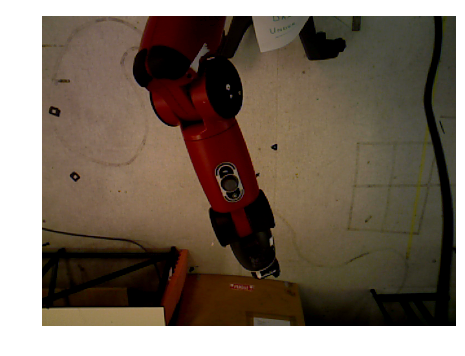

In [9]:
image = data[0]['rgb_image']
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## Prepare data

In [29]:
prepared_img = lambda img: np.transpose(cv2.resize(img, (network_params['image_width'], network_params['image_height'])),(2,1,0)).flatten()

In [30]:
subset_data = data[0:1000]

In [34]:


prepared_obs = np.array([ np.r_[s['position'],s['velocity'], prepared_img(s['rgb_image'])] for s in subset_data ])
prepared_tgt = np.array([ np.r_[s['ee_point'],s['ee_point']+np.array([0,0,0.05]),s['ee_point']+np.array([0,0.05,0.05])] for s in subset_data ])
prepared_prc = np.array([ np.eye(s['ee_point'].shape[0]) for s in subset_data ])

prepared_data = {'obs' : prepared_obs, 'tgt': prepared_tgt, 'prc': prepared_prc}

## Save prepared data

In [35]:
import aml_robot
from aml_io.io_tools import save_data, load_data
prepared_data_path = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'data', 'prepared_data.pkl'))

In [36]:
save_data(prepared_data,prepared_data_path)

## Load prepared data

In [37]:
prepared_data = load_data(prepared_data_path)

In [38]:
prepared_obs = prepared_data['obs']
prepared_tgt = prepared_data['tgt']
prepared_prc = prepared_data['prc']

In [39]:
prepared_data['obs'][0].shape

(150542,)

## Training

In [40]:
# Initialialise session and variables

init_op = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init_op)
init_fn(sess)

In [41]:
iterations = 2000 # Epochs
batch_size = 3
train_size = 200#2000
batches_per_epoch = np.floor(train_size / batch_size)
idx = range(train_size)
np.random.shuffle(idx)
sample_idx = 0

In [42]:
loss = []
average_loss = 0
train_loss = 0
for i in range(iterations):
    # Load in data for this batch.
    start_idx = int(i * batch_size %(batches_per_epoch * batch_size))
    idx_i = idx[start_idx:start_idx+batch_size]
    
    feed_dict = {input_tensor: prepared_obs[idx_i],
                 position: prepared_tgt[idx_i]}
    
    sample_idx = sample_idx + 1
    
    #t = policy.sess.run(policy.act_op, feed_dict={policy.obs_tensor: np.expand_dims(prepared_obs[idx_i][0], 0)})
    
#     feed_dict={input_tensor: np.expand_dims(np.r_[np.zeros(deg_state),image],axis=0),
#                                      position: np.expand_dims(points,axis=0)
#                                     }
    
    with tf.device("/gpu:0"):
        train_loss, _ = sess.run([loss_op,train_op],feed_dict = feed_dict)
    
    
    average_loss += train_loss
    if (i+1) % 50 == 0:
        print('tensorflow iteration %d, average loss %f',
                             i+1, average_loss / 50)
        loss.append(average_loss)
        average_loss = 0

ValueError: Cannot feed value of shape (3, 9) for Tensor u'pose:0', which has shape '(?, 3)'

In [15]:
######## SAVING MODEL #######
save_path = saver.save(sess, "model.ckpt")
print("Model saved in file: %s" % save_path)
    

# sess.close()

Model saved in file: model.ckpt


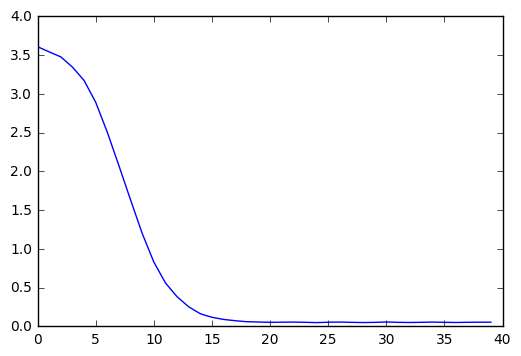

In [16]:
plt.plot(loss)

## Fake training

In [3]:
# Run a simple test with a fake image
image, random_image = fakeImageInput(network_params)

### Training ###

p0 = np.array([0,0,0])
p1 = np.array([0,1,0])
p2 = np.array([0,1,1])
points = np.concatenate((p0,p1,p2))

for iteration in range(iterations):
    
    # Load in data for this batch.
    start_idx = int(i * batch_size)
    idx_i = idx[start_idx:start_idx+batch_size]
    
    with tf.device("/gpu:0"):
        loss = sess.run([loss_op,train_op],feed_dict={input_tensor: np.expand_dims(np.r_[np.zeros(deg_state),image],axis=0),
                                     position: np.expand_dims(points,axis=0)
                                    })

        # print every 50 iters
        if iteration%100 == 0:
            print "iteration %d loss: "%(iteration), loss

            
######## SAVING MODEL #######
save_path = saver.save(sess, "model.ckpt")
print("Model saved in file: %s" % save_path)
    

sess.close()


iteration 0 loss:  [0.060000017, None]
iteration 100 loss:  [0.058676071, None]
iteration 200 loss:  [0.056601781, None]
iteration 300 loss:  [0.05064946, None]
iteration 400 loss:  [0.038728632, None]
iteration 500 loss:  [0.024177203, None]
iteration 600 loss:  [0.011285049, None]
iteration 700 loss:  [0.0034767813, None]
iteration 800 loss:  [0.00067143812, None]
iteration 900 loss:  [8.7477878e-05, None]
Model saved in file: model.ckpt


## Testing

In [17]:
def draw_features(features,image_data):
    
    try:
        (rows,cols,channels) = image_data.shape
        i_feat = 0
        while i_feat < len(features):
            cx = cols/2 + int(float(features[i_feat]*cols)/2)
            cy = rows/2 + int(float(features[i_feat+1]*rows)/2)
            cv2.circle(image_data, (cx,cy), 10, 255)
            i_feat += 2
    except Exception as e:
        print(e)

    return image_data

def show_image(image):

    cv2.imshow("RGB Image window", image)

    cv2.waitKey(1)

# features = policy.sess.run(policy.feat_op, feed_dict={policy.obs_tensor: np.expand_dims(prepared_obs[idx_i][0], 0)})
# features = features[0]
# print(features)

In [19]:
features = sess.run(features_op, feed_dict={input_tensor: np.expand_dims(prepared_obs[idx_i][0], 0)})
features = features[0]
print(features)

[-0.49988556 -0.49994132 -0.49998328 -0.49997923 -0.49997354 -0.49997303
 -0.49997246 -0.49996975]


In [23]:
image_data = data[0]['rgb_image']
img = draw_features(features,image_data)

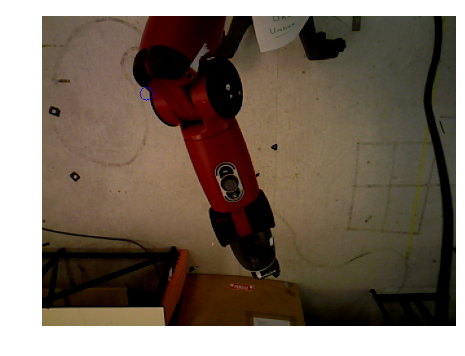

In [24]:
image = data[0]['rgb_image']
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
#np.expand_dims(prepared_obs[i],0)

In [28]:
#err_tmp = err
err = []
for i in range(0,200):
    features, point = sess.run([features_op,fc_op], feed_dict={input_tensor: np.expand_dims(prepared_obs[i], 0)})
    point = point[0]
    features = features[0]
    image_data = data[i]['rgb_image']
    #image_data = cv2.resize(image_data, (network_params['image_width'], network_params['image_height']))
    img = draw_features(features,image_data)
    show_image(img)
    
    err_i = (data[i]['ee_point'] - point)
    err.append( np.dot(err_i,err_i.T) )
    

In [ ]:
plt.plot(err)
print("Avg err: ", np.sum(err)/len(err), " meters")